# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import sys
sys.path.append('/home/harrit/anaconda3/envs/project1/lib/python3.5/site-packages')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


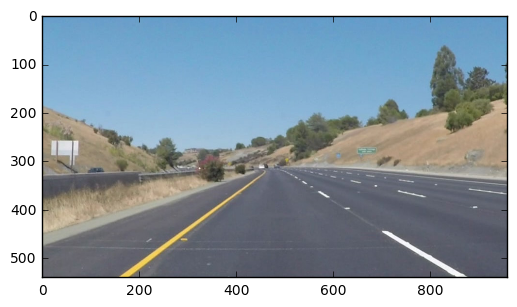

In [107]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [144]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            
def hough_lines_img(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines



def segregate_left_right(img, rho, theta, threshold, min_line_len, max_line_gap,cropheight,cropwidth,cv_img_cropped):
        #Real Time matrices for each frame
        X = []
        Y = []
        X_R = []
        Y_R = []
        X_L = []
        Y_L = []
        X_c = []
        Y_c = []
        X_c = []
        Y_c = []
        slope_c = 0
    
        for line in hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
                for x1,y1,x2,y2 in line:
                    #Writing detected lanes on the images
                    #cv2.line(cv_img_cropped,(x1,y1),(x2,y2),(0,255,0),1)
                    X.append(x1)
                    X.append(x2)
                    Y.append(y1)
                    Y.append(y2)

                    #-----------------------------------------------------------------------------------------#




                    #--------------------Segmentation into left and right lane module-------------------------#
                    #If a point lies on left half of screen classify it as left 
                    if x1 < cropwidth/2:
                        X_L.append(x1)
                        Y_L.append(y1)
                        #Check case for sharp turns. Analyzing the top 1/3rd part of screen. If a point lies near half of the screen, add it to a critical matrix
                        if y1 < cropheight/3:
                            if abs(x1 - cropwidth/2) < 6:
                                X_c.append(x1)
                                Y_c.append(y1)
                                slope_c = math.degrees(math.atan((y2-y1)/(x2-x1)))

                    if x2 < cropwidth/2:
                        X_L.append(x2)
                        Y_L.append(y2)
                        #Check case for sharp turns. Analyzing the top 1/3rd part of screen. If a point lies near half of the screen, add it to a critical matrix
                        if y2 < cropheight/3:
                            if abs(x2 - cropwidth/2) < 6:
                                X_c.append(x2)
                                Y_c.append(y2)
                                slope_c = math.degrees(math.atan((y2-y1)/(x2-x1)))

                        #cv2.line(cv_img_cropped,(x1,y1),(x2,y2),(255,0,0),1)

                    #Right line classification
                    if x1 >= cropwidth/2:
                        X_R.append(x1)
                        Y_R.append(y1)
                        #Check case for sharp turns. Analyzing the top 1/3rd part of screen. If a point lies near half of the screen, add it to a critical matrix
                        if y1 < cropheight/3:
                            if abs(x1 - cropwidth/2) < 6:
                                X_c.append(x1)
                                Y_c.append(y1)
                                slope_c = math.degrees(math.atan((y2-y1)/(x2-x1)))

                    if x2 >= cropwidth/2:
                        X_R.append(x2)
                        Y_R.append(y2)
                        #Check case for sharp turns. Analyzing the top 1/3rd part of screen. If a point lies near half of the screen, add it to a critical matrix
                        if y2 < cropheight/3:
                            if abs(x2 - cropwidth/2) < 6:
                                X_c.append(x2)
                                Y_c.append(y2)
                                slope_c = math.degrees(math.atan((y2-y1)/(x2-x1)))

                        #cv2.line(cv_img_cropped,(x1,y1),(x2,y2),(0,0,255),1)

        if not slope_c == 0:
            if not Y_L: 
                slope_ref_L = 45
            else: 
                slope_ref_L = math.degrees(math.atan((max(Y_L)-min(Y_c))/(X_L[Y_L.index(max(Y_L))]-cropwidth/2)))

            if not Y_R: 
                slope_ref_R = 45
            else: 
                slope_ref_R = math.degrees(math.atan((max(Y_R)-min(Y_c))/(X_R[Y_R.index(max(Y_R))]-cropwidth/2)))

        #Tackling the sharp turn critical cases. If lane is truning right, remove falsely setected points in the right set of points and add them to the left set of points		
        if slope_c < 0:
            for xr, yr in zip(X_R,Y_R):
                if yr <= min(Y_c) and X_R[Y_R.index(yr)] > cropwidth/2:
                    slope_i = math.degrees(math.atan((yr-min(Y_c))/(X_R[Y_R.index(yr)]-cropwidth/2)))
                    if abs(slope_i) > abs(slope_ref_R) or X_R[Y_R.index(yr)] in X_c:
                        X_L.append(X_R[Y_R.index(yr)])
                        X_R.remove(X_R[Y_R.index(yr)])
                        Y_L.append(yr)
                        Y_R.remove(yr)
                    
                    
        #Tackling the sharp turn critical cases. If lane is truning left, remove falsely setected points in the left set of points and add them to the right set of points
        if slope_c > 0:
            for xl, yl in zip(X_L,Y_L):
                if yl <= min(Y_c) and X_L[Y_L.index(yl)] < cropwidth/2:
                    slope_i = math.degrees(math.atan((yl-min(Y_c))/(X_L[Y_L.index(yl)]-cropwidth/2)))
                    if abs(slope_i) > abs(slope_ref_L) or X_L[Y_L.index(yl)] in X_c:
                        X_R.append(X_L[Y_L.index(yl)])
                        X_L.remove(X_L[Y_L.index(yl)])
                        Y_R.append(yl)
                        Y_L.remove(yl)
            
        #Dividing the frame vertically into six parts and averaging out points in each part for left set of points
        n1 = 0
        y_sum1 = 0
        x_sum1 = 0
        n2 = 0
        y_sum2 = 0
        x_sum2 = 0
        n3 = 0
        y_sum3 = 0
        x_sum3 = 0
        n4 = 0
        y_sum4 = 0
        x_sum4 = 0
        n5 = 0
        y_sum5 = 0
        x_sum5 = 0
        n6 = 0
        y_sum6 = 0
        x_sum6 = 0
        for y, x in zip(Y_L,X_L):
            if y < cropheight/6: 
                n1 += 1
                y_sum1 += y
                x_sum1 += x
            elif y < cropheight/3 and y >= cropheight/6: 
                n2 += 1
                y_sum2 += y
                x_sum2 += x
            elif y < cropheight/2 and y >= cropheight/3: 
                n3 += 1
                y_sum3 += y
                x_sum3 += x
            elif y < 2*cropheight/3 and y >= cropheight/2: 
                n4 += 1
                y_sum4 += y
                x_sum4 += x
            elif y < 5*cropheight/6 and y >= 2*cropheight/3: 
                n5 += 1
                y_sum5 += y
                x_sum5 += x
            elif y <= cropheight and y >= 5*cropheight/6: 
                n6 += 1
                y_sum6 += y
                x_sum6 += x

        if not n1 == 0:
            y_av1_l = y_sum1/n1
            x_av1_l = x_sum1/n1

        if not n2 == 0:	
            y_av2_l = y_sum2/n2
            x_av2_l = x_sum2/n2
            
        if not n3 == 0:
            y_av3_l = y_sum3/n3
            x_av3_l = x_sum3/n3

        if not n4 == 0:
            y_av4_l = y_sum4/n4
            x_av4_l = x_sum4/n4	

        if not n5 == 0:
            y_av5_l = y_sum5/n5
            x_av5_l = x_sum5/n5

        if not n6 == 0:
            y_av6_l = y_sum6/n6
            x_av6_l = x_sum6/n6


        #Handling cases for left points in which there is no point in a specific part. If no point is detected then an averaged point is generated by interpolation from the adjacent parts.
        if n1 == 0: 
            #The vertical height of averaged point is the vertical middle point of the respective part 
            y_av1_l = cropheight/12
            n1 = 1
            if not n2 == 0:
                x_av1_l = x_av2_l  
            else:
                if not n3 == 0:
                    x_av1_l = x_av3_l
                else: 
                    if not n4 == 0:
                        x_av1_l = x_av4_l
                    else:
                        if not n5 == 0:
                            x_av1_l = x_av5_l 
                        else:
                            if not n6 == 0:
                                x_av1_l = x_av6_l
                            else:
                                x_av1_l = cropwidth/2

        if n2 == 0:
            y_av2_l = cropheight/4
            n2 = 1
            if not n3 == 0:
                x_av2_l = (x_av1_l + x_av3_l)/2 
            else: 
                if not n4 == 0:
                    x_av2_l = (x_av1_l + x_av4_l)/2 
                else:
                    if not n5 == 0:
                        x_av2_l = (x_av1_l + x_av5_l)/2 
                    else:
                        if not n6 == 0:
                            x_av2_l = (x_av1_l + x_av6_l)/2 
                        else:
                            x_av2_l = x_av1_l - cropheight/4 

        if n3 == 0: 
            y_av3_l = 5*cropheight/12
            n3 = 1
            if not n4 == 0:
                x_av3_l = (x_av2_l + x_av4_l)/2 
            else:
                if not n5 == 0:
                    x_av3_l = (x_av2_l + x_av5_l)/2 
                else:
                    if not n6 == 0:
                        x_av3_l = (x_av2_l + x_av6_l)/2 
                    else:
                        x_av3_l = x_av2_l - cropheight/4 
                        
        if n4 == 0:
            y_av4_l = 7*cropheight/12
            n4 = 1
            if not n5 == 0:
                x_av4_l = (x_av3_l + x_av5_l)/2 
            else:
                if not n6 == 0:
                    x_av4_l = (x_av3_l + x_av6_l)/2 
                else:
                    x_av4_l = x_av3_l - cropheight/4

        if n5 == 0: 
            y_av5_l = 9*cropheight/12
            n5 = 1
            if not n6 == 0:
                x_av5_l = (x_av4_l + x_av6_l)/2 
            else:
                x_av5_l = x_av4_l - cropheight/4
    
        if n6 == 0:
            y_av6_l = 11*cropheight/12
            n6 = 1
            x_av6_l = x_av5_l - cropheight/4

        Y1_l = cropheight
        X1_l = x_av5_l - ((Y1_l - y_av5_l) * (x_av4_l - x_av5_l)/(y_av5_l - y_av4_l)) 
        
        Y2_l = cropheight/2 + 50
        X2_l = x_av4_l + ((y_av4_l - Y2_l) * (x_av4_l - x_av5_l)/(y_av5_l - y_av4_l)) 
        
        y_av6_l = (y_av5_l + Y1_l)/2
        x_av6_l = x_av5_l - ((y_av6_l - y_av5_l) * (x_av4_l - x_av5_l)/(y_av5_l - y_av4_l))
            
        #Drawing the averaged lines for left side
        #cv2.line(cv_img_cropped,(int(x_av1_l),int(y_av1_l)),(int(x_av2_l),int(y_av2_l)),(255,0,0),15)
        #cv2.line(cv_img_cropped,(int(x_av2_l),int(y_av2_l)),(int(x_av3_l),int(y_av3_l)),(255,0,0),15)
        #cv2.line(cv_img_cropped,(int(x_av3_l),int(y_av3_l)),(int(x_av4_l),int(y_av4_l)),(255,0,0),15)
        cv2.line(cv_img_cropped,(int(X2_l),int(Y2_l)),(int(x_av4_l),int(y_av4_l)),(255,0,0),15)
        cv2.line(cv_img_cropped,(int(x_av4_l),int(y_av4_l)),(int(x_av5_l),int(y_av5_l)),(255,0,0),15)
        cv2.line(cv_img_cropped,(int(x_av5_l),int(y_av5_l)),(int(x_av6_l),int(y_av6_l)),(255,0,0),15)
        cv2.line(cv_img_cropped,(int(X1_l),int(Y1_l)),(int(x_av6_l),int(y_av6_l)),(255,0,0),15)


        #Dividing the frame vertically into six parts and averaging out points in each part for right set of points
        n1 = 0
        y_sum1 = 0
        x_sum1 = 0
        n2 = 0
        y_sum2 = 0
        x_sum2 = 0
        n3 = 0
        y_sum3 = 0
        x_sum3 = 0
        n4 = 0
        y_sum4 = 0
        x_sum4 = 0
        n5 = 0
        y_sum5 = 0
        x_sum5 = 0
        n6 = 0
        y_sum6 = 0
        x_sum6 = 0
        for y, x in zip(Y_R,X_R):
            if y < cropheight/6: 
                n1 += 1
                y_sum1 += y
                x_sum1 += x
            elif y < cropheight/3 and y >= cropheight/6: 
                n2 += 1
                y_sum2 += y
                x_sum2 += x
            elif y < cropheight/2 and y >= cropheight/3: 
                n3 += 1
                y_sum3 += y
                x_sum3 += x
            elif y < 2*cropheight/3 and y >= cropheight/2: 
                n4 += 1
                y_sum4 += y
                x_sum4 += x
            elif y < 5*cropheight/6 and y >= 2*cropheight/3: 
                n5 += 1
                y_sum5 += y
                x_sum5 += x
            elif y <= cropheight and y >= 5*cropheight/6: 
                n6 += 1
                y_sum6 += y
                x_sum6 += x

        if not n1 == 0:
            y_av1_r = y_sum1/n1
            x_av1_r = x_sum1/n1

        if not n2 == 0:
            y_av2_r = y_sum2/n2
            x_av2_r = x_sum2/n2
            
        if not n3 == 0:
            y_av3_r = y_sum3/n3
            x_av3_r = x_sum3/n3

        if not n4 == 0:
            y_av4_r = y_sum4/n4
            x_av4_r = x_sum4/n4

        if not n5 == 0:
            y_av5_r = y_sum5/n5
            x_av5_r = x_sum5/n5

        if not n6 == 0:
            y_av6_r = y_sum6/n6 
            x_av6_r = x_sum6/n6

        #Handling cases for left points in which there is no point in a specific part. If no point is detected then an averaged point is generated by interpolation from the adjacent parts
        if n1 == 0: 
            y_av1_r = cropheight/12
            n1 = 1
            if not n2 == 0:
                x_av1_r = x_av2_r 
            else:
                if not n3 == 0:
                    x_av1_r = x_av3_r
                else: 
                    if not n4 == 0:
                        x_av1_r = x_av4_r
                    else:
                        if not n5 == 0:
                            x_av1_r = x_av5_r 
                        else:
                            if not n6 == 0:
                                x_av1_r = x_av6_r
                            else:
                                x_av1_r = cropwidth/2

        if n2 == 0:
            y_av2_r = cropheight/4
            n2 = 1
            if not n3 == 0:
                x_av2_r = (x_av1_r + x_av3_r)/2 
            else: 
                if not n4 == 0:
                    x_av2_r = (x_av1_r + x_av4_r)/2 
                else:
                    if not n5 == 0:
                        x_av2_r = (x_av1_r + x_av5_r)/2 
                    else:
                        if not n6 == 0:
                            x_av2_r = (x_av1_r + x_av6_r)/2 
                        else:
                            x_av2_r = x_av1_r + cropheight/4

        if n3 == 0: 
            y_av3_r = 5*cropheight/12
            n3 = 1
            if not n4 == 0:
                x_av3_r = (x_av2_r + x_av4_r)/2 
            else:
                if not n5 == 0:
                    x_av3_r = (x_av2_r + x_av5_r)/2 
                else:
                    if not n6 == 0:
                        x_av3_r = (x_av2_r + x_av6_r)/2 
                    else:
                        x_av3_r = x_av2_r + cropheight/4
                        
        if n4 == 0:
            y_av4_r = 7*cropheight/12
            n4 = 1
            if not n5 == 0:
                x_av4_r = (x_av3_r + x_av5_r)/2 
            else:
                if not n6 == 0:
                    x_av4_r = (x_av3_r + x_av6_r)/2 
                else:
                    x_av4_r = x_av3_r + cropheight/4

        if n5 == 0: 
            y_av5_r = 9*cropheight/12
            n5 = 1
            if not n6 == 0:
                x_av5_r = (x_av4_r + x_av6_r)/2 
            else:
                x_av5_r = x_av4_r + cropheight/4

        if n6 == 0:
            y_av6_r = 11*cropheight/12 
            n6 = 1
            x_av6_r = x_av5_r + cropheight/4 
                        
        Y1_r = cropheight
        X1_r = x_av5_r + ((Y1_r - y_av5_r) * (x_av5_r - x_av4_r)/(y_av5_r - y_av4_r)) 
        
        Y2_r = cropheight/2 + 50
        X2_r = x_av4_r - ((y_av4_r - Y2_r) * (x_av5_r - x_av4_r)/(y_av5_r - y_av4_r))
        
        y_av6_r = (y_av5_r + Y1_r)/2
        x_av6_r = x_av4_r - ((y_av4_r - y_av6_r) * (x_av5_r - x_av4_r)/(y_av5_r - y_av4_r))
        
        
        #Drawing the averaged lines for right side
        #cv2.line(cv_img_cropped,(int(x_av1_r),int(y_av1_r)),(int(x_av2_r),int(y_av2_r)),(0,255,255),15)
        #cv2.line(cv_img_cropped,(int(x_av2_r),int(y_av2_r)),(int(x_av3_r),int(y_av3_r)),(0,255,255),15)
        #cv2.line(cv_img_cropped,(int(x_av3_r),int(y_av3_r)),(int(x_av4_r),int(y_av4_r)),(0,255,255),15)
        cv2.line(cv_img_cropped,(int(X2_r),int(Y2_r)),(int(x_av4_r),int(y_av4_r)),(0,255,255),15)
        cv2.line(cv_img_cropped,(int(x_av4_r),int(y_av4_r)),(int(x_av5_r),int(y_av5_r)),(0,255,255),15)
        cv2.line(cv_img_cropped,(int(x_av5_r),int(y_av5_r)),(int(x_av6_r),int(y_av6_r)),(0,255,255),15)
        cv2.line(cv_img_cropped,(int(X1_r),int(Y1_r)),(int(x_av6_r),int(y_av6_r)),(0,255,255),15)




        #-------------Middle line trajectory generation module---------------#
        xm1 = (x_av1_r + x_av1_l)/2
        ym1 = (y_av1_r + y_av1_l)/2
        xm2 = (x_av2_r + x_av2_l)/2
        ym2 = (y_av2_r + y_av2_l)/2
        xm3 = (x_av3_r + x_av3_l)/2
        ym3 = (y_av3_r + y_av3_l)/2
        xm4 = (x_av4_r + x_av4_l)/2
        ym4 = (y_av4_r + y_av4_l)/2
        xm5 = (x_av5_r + x_av5_l)/2
        ym5 = (y_av5_r + y_av5_l)/2
        xm6 = (x_av6_r + x_av6_l)/2
        ym6 = (y_av6_r + y_av6_l)/2
        
        Y1 = (Y1_r + Y1_l)/2
        Y2 = (Y2_r + Y2_l)/2
        X1 = (X1_r + X1_l)/2
        X2 = (X2_r + X2_l)/2
        
        #points = np.array([(xm2, ym2), (xm3, ym3), (xm4, ym4), (xm5, ym5)])
        #x = points[:,0]
        #y = points[:,1]
        #z = np.polyfit(x, y, 2)
        #f = np.poly1d(z)
        #x_new = np.linspace(x[0], x[-1], 20)
        #y_new = f(x_new)
        
        #for i in range(0,len(x_new)-1):
          #     cv2.line(cv_img_cropped,(int(x_new[i]),int(y_new[i])),(int(x_new[i+1]),int(y_new[i+1])),(255,255,255),2)
        
        #Drawing the middle line trajectory
        #cv2.line(cv_img_cropped,(int(xm2),int(ym2)),(int(xm3),int(ym3)),(255,255,255),2)
        #cv2.line(cv_img_cropped,(int(xm3),int(ym3)),(int(xm4),int(ym4)),(255,255,255),2)
        #cv2.line(cv_img_cropped,(int(xm4),int(ym4)),(int(xm5),int(ym5)),(255,255,255),2)
        #cv2.line(cv_img_cropped,(int(xm4),int(ym4)),(int(xm5),int(ym5)),(255,255,255),2)
        #cv2.line(cv_img_cropped,(int(X2),int(Y2)),(int(xm4),int(ym4)),(255,255,255),2)
        cv2.line(cv_img_cropped,(int(xm6),int(ym6)),(int(X2),int(Y2)),(255,255,255),2)
        #cv2.line(cv_img_cropped,(int(xm5),int(ym5)),(int(xm6),int(ym6)),(255,255,255),2)
        #cv2.line(cv_img_cropped,(int(xm6),int(ym6)),(int(X1),int(Y1)),(255,255,255),2)
        
        steering_angle = math.degrees(math.atan((Y2-ym6)/(X2-xm6)))
        
        if steering_angle < 0 and (90+steering_angle) > 10:
            cv2.putText(cv_img_cropped,'right--' + str(int(90 + steering_angle)),(int(cropwidth/2 - 100),int(cropheight)), 1, 4,(0,255,255),2)   
        elif steering_angle > 0 and (90-steering_angle) > 10:
            cv2.putText(cv_img_cropped,'left--' + str(int(90 - steering_angle)),(int(cropwidth/2 - 100),int(cropheight)), 1, 4,(255,0,0),2)    
        else:
            cv2.putText(cv_img_cropped,'straight',(int(cropwidth/2-50),int(cropheight)), 1, 4,(255,255,255),2)
            
        return cv_img_cropped

        
        
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [157]:
import os
list = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

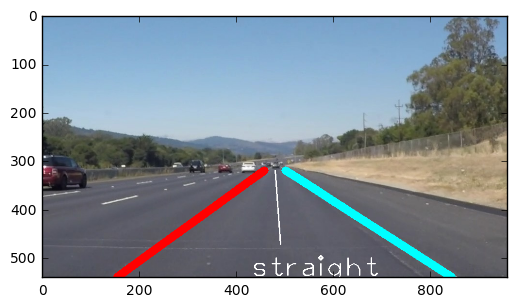

In [158]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# red line shows the left line
# blue line shows the right line
# white line shows the trajectory that the car has to follow

for i in range(0,len(list)):
    imageName = list[i]
    image1 = mpimg.imread('test_images/' + imageName)
    imshape = image1.shape
    vertices = np.array([[(0.125*imshape[1],imshape[0]),(0.458*imshape[1], 0.592*imshape[0]), (0.531*imshape[1], 0.592*imshape[0]), (0.916*imshape[1],imshape[0])]], dtype=np.int32)
    
    grayscale_img = grayscale(image1)
    filtered_img = gaussian_blur(grayscale_img,7)
    canny_img = canny(filtered_img,10,150)
    
    masked_img = region_of_interest(canny_img,vertices)
    hough_img = hough_lines_img(canny_img,0.5,np.pi/360,1,1,1) 
    ch = imshape[0]
    cw = imshape[1] 
    result_img = segregate_left_right(masked_img,0.5,np.pi/360,1,1,1,ch,cw,image1)
    plt.imshow(result_img)
    plt.savefig('test_images/' + str(i) + '.jpg')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [145]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    imshape = image.shape
    vertices = np.array([[(0.125*imshape[1],imshape[0]),(0.458*imshape[1], 0.592*imshape[0]), (0.531*imshape[1], 0.592*imshape[0]), (0.916*imshape[1],imshape[0])]], dtype=np.int32)
    
    grayscale_img = grayscale(image)
    filtered_img = gaussian_blur(grayscale_img,7)
    canny_img = canny(filtered_img,10,150)
    
    masked_img = region_of_interest(canny_img,vertices)
    hough_img = hough_lines_img(canny_img,0.5,np.pi/360,1,1,1) 
    ch = imshape[0]
    cw = imshape[1] 
    result_img = segregate_left_right(masked_img,0.5,np.pi/360,1,1,1,ch,cw,image)

    return result_img

Let's try the one with the solid white lane on the right first ...

In [146]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



100%|█████████▉| 221/222 [00:13<00:00, 15.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 29s, sys: 768 ms, total: 1min 30s
Wall time: 13.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [148]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [137]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:43<00:00, 12.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 4min 48s, sys: 2.07 s, total: 4min 50s
Wall time: 44.3 s


In [149]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


#-----------------------------------------------------------------------------------------------------------------#

The pipeline begins with defining the vertices of the region of interest with dimensions being defined as percentages of the image width and height and not fixed values which helps it to be applicable to any general frame with any resolution. 

The next step is converting the image to grayscale followed by Gaussian filtering and canny edge detection. These are followed by hough transform and segregation of detected lines into left and right lanes. The lanes are extrapolated based on the slopes. 

I had already made the left right segregation code in my grad school autonomous vehicle project and made changes to it to optimize it for the videos. The segregation is based on positioning of detected lines wrt screen center line and the case for sharp turns is also taken into account. 

A mid line trajectory with white color and steering angle has been also shown. The right lane has been indicated with blue and left with red.

The current extrapolation method doesn't mark curves and is best suited for straight lines and not so sharp turns. The problem can be solved by using a quadratic curve extrapolation instead of slope based linear extrapolation or going for an advanced algorithm like b-spline. I could have also added averaging and smoothing based on previous frames so that there are major jitters or fluctuations in the detected lines. This issue is a big problem in the extra challenge video. 

#-----------------------------------------------------------------------------------------------------------------#

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [147]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



100%|██████████| 251/251 [00:40<00:00,  6.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 4min 21s, sys: 2.11 s, total: 4min 23s
Wall time: 42 s


In [151]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))